In [ ]:
!pip install keras_core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 16.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import os
import time
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

os.environ["KERAS_BACKEND"] = "torch"
import keras_core as keras

Using PyTorch backend.


# The Perceptron and beyond

In this section, we consider a regression task where the underlying data generation process is as follows:
$$ y = - \sin{(0.8 * x)}$$

Note that in this example there is no noise in the data, a case that you will rarely encounter in practice.

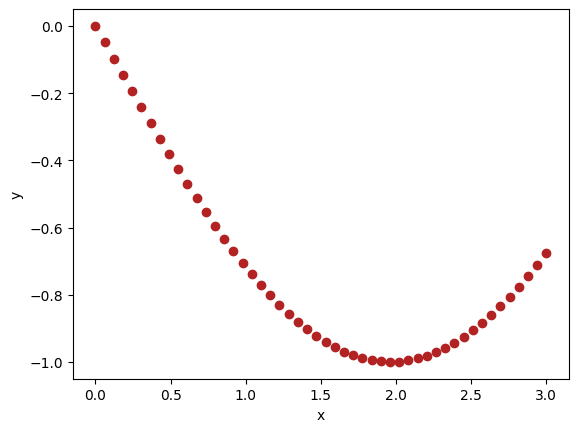

In [ ]:
x_train = np.linspace(0, 3, 50)
y_train = - np.sin(0.8*x_train)

plt.figure()
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x_train, y_train, color= "firebrick")
plt.show()

The following function can be used to instantiate the perceptron

In [ ]:
def perceptron(input_shape= [1], units= 1, activation= None):
    model = keras.Sequential(
        [
            keras.layers.Input(shape= input_shape),
            keras.layers.Dense(units= units, activation= activation)
        ]
    )
    return model

linear_model = perceptron()

You can vizualize a summary of your model by commenting out the following line. Here it is an affine function in dimension 1, thus having two parameters.

In [ ]:
linear_model.summary()

To be able to reset weights later:

In [ ]:
initial_weights = linear_model.get_weights()

To fit a model in keras, one must first compile it, that is specify the loss and optimizer. Here they are respectively chosen as the mean squared error and gradient descent. Observe that the batch size is the same as the size of the training dataset, resulting in batch gradient descent.

You can play with the learning rate and number of epochs to understand how the training algorithm behaves.

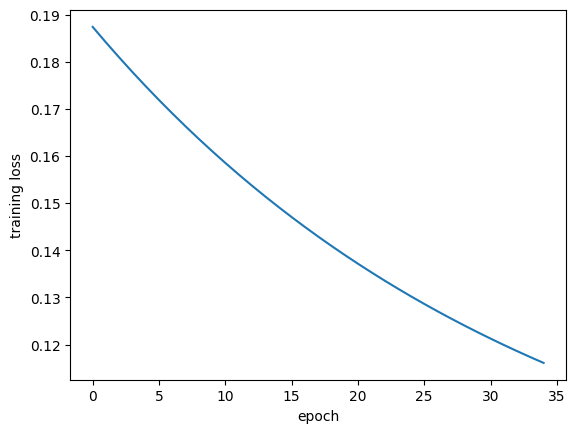

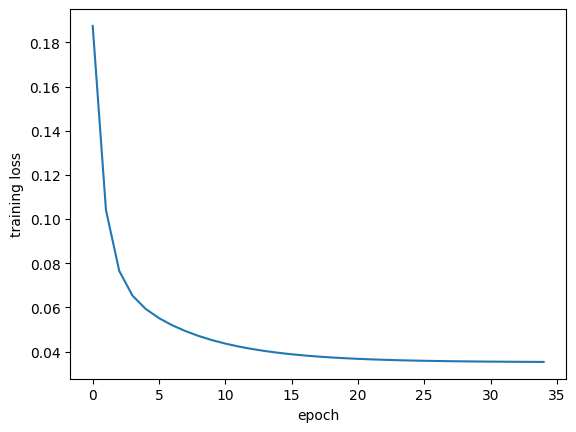

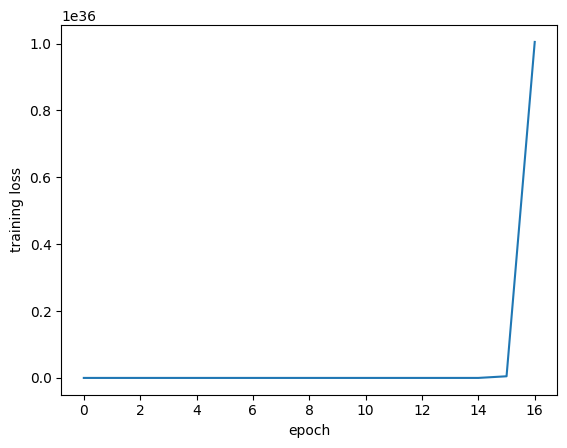

In [ ]:
for lr in [0.002, 0.2, 2.0]:
    linear_model.set_weights(initial_weights)
    linear_model.compile(
        loss = keras.losses.MeanSquaredError(),
        optimizer = keras.optimizers.SGD(learning_rate= lr)
    )
    history = linear_model.fit(x_train, y_train, epochs= 35, batch_size= 50, verbose=False)

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('training loss')
    plt.plot(history.history['loss'])
    plt.show()

Having trained the model, we can now use it in prediction.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


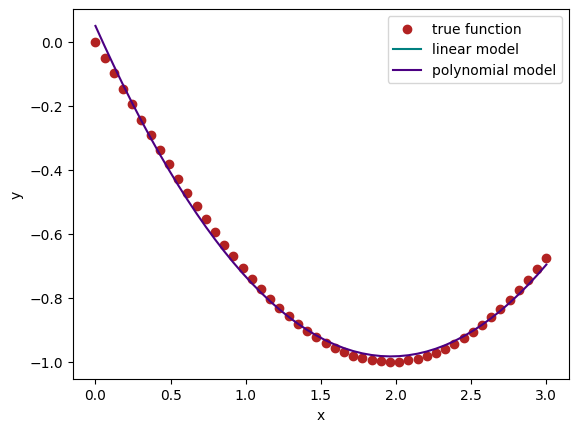

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

y_pred_linear = linear_model.predict(x_train)

poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(x_train.reshape(-1, 1), y_train)
y_pred_poly = poly_model.predict(x_train.reshape(-1, 1))

plt.figure()
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x_train, y_train, color='firebrick', label= 'true function')
plt.plot(x_train, y_pred_linear, color= 'teal', label= 'linear model')
plt.plot(x_train, y_pred_poly, color="indigo", label="polynomial model")
plt.legend()
plt.show()

Beyond this simple perceptron, we now consider a 2-layers neural network model.

In [ ]:
def neural_net_2layers(input_shape= [1], units= 16, activation= 'sigmoid'):
    model = keras.Sequential(
        [
            keras.layers.Input(shape= input_shape),
            keras.layers.Dense(units= units, activation= activation),
            keras.layers.Dense(units= 1)
        ]
    )
    return model

You can train the model, and play with the hyperparameters to answer the questions.

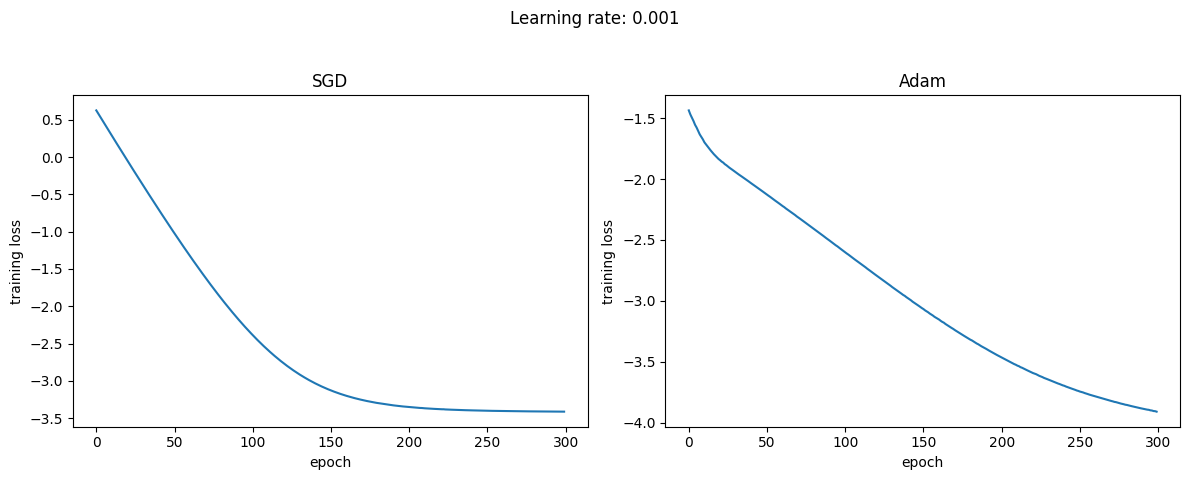

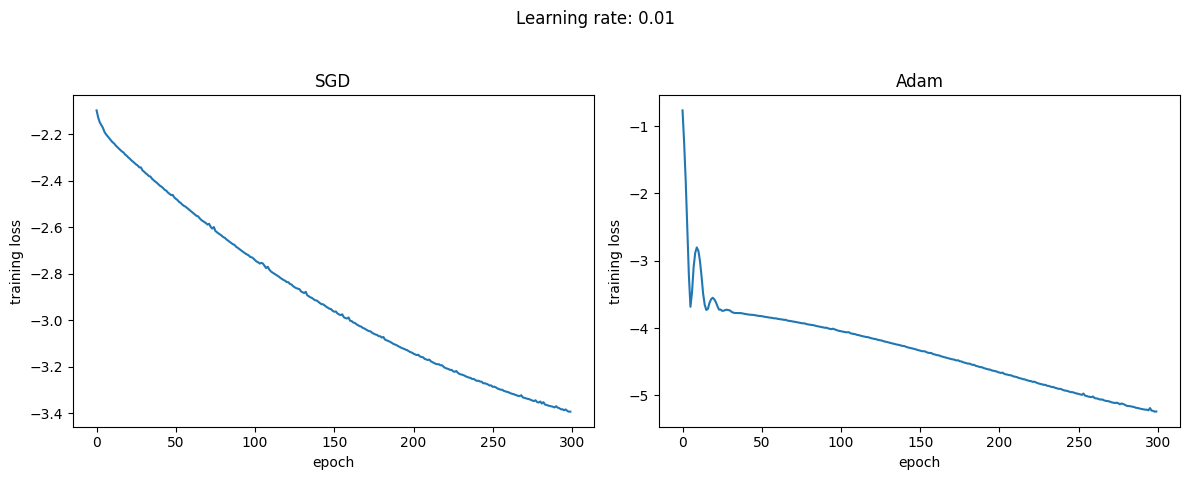

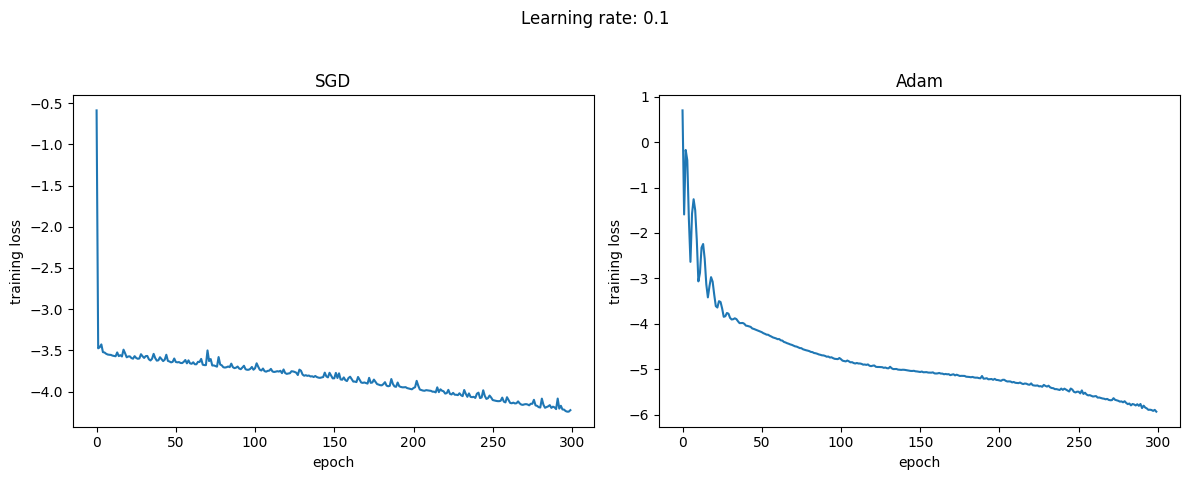

In [ ]:
for lr in [0.001, 0.01, 0.1]:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # Create a figure with 2 subplots
    fig.suptitle(f"Learning rate: {lr}")

    for i, (optim_name, optim_class) in enumerate([('SGD', keras.optimizers.SGD), ('Adam', keras.optimizers.Adam)]):
        net = neural_net_2layers(units= 10)

        net.compile(
            loss = keras.losses.MeanSquaredError(),
            optimizer = optim_class(learning_rate= lr)
        )

        history = net.fit(x_train, y_train, epochs= 300, batch_size= 25, verbose= 0)
        axes[i].plot(np.log(history.history['loss'])) # Plot on the i-th subplot
        axes[i].set_title(optim_name) # Set title for the subplot
        axes[i].set_xlabel('epoch')
        axes[i].set_ylabel('training loss')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


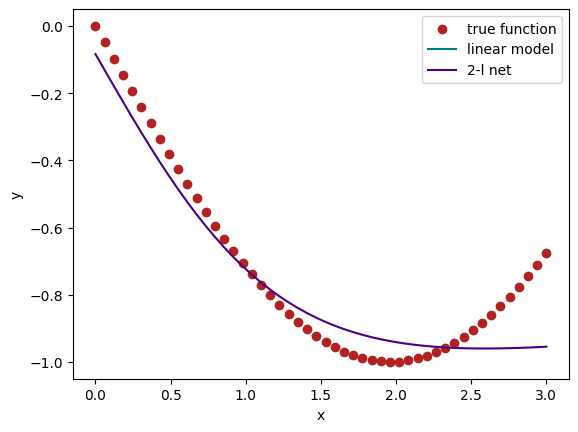

In [ ]:
net = neural_net_2layers(units= 10)

net.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.SGD(learning_rate= 0.2)
)

history = net.fit(x_train, y_train, epochs= 300, batch_size= 25, verbose= 0)

y_pred_2l = net.predict(x_train)

plt.figure()
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x_train, y_train, color='firebrick', label = 'true function')
plt.plot(x_train, y_pred_linear, color= 'teal', label = 'linear model')
plt.plot(x_train, y_pred_2l, color= 'indigo', label = '2-l net')
plt.legend()
plt.show()

In [ ]:
def mlp(input_shape=[1], units=16, activation="sigmoid", num_layers=2):
    layers = [keras.layers.Input(shape=input_shape)]
    num_hidden_layers = num_layers - 1
    for i in range(num_hidden_layers):
        layers.append(keras.layers.Dense(units=units, activation=activation))
        if i < num_hidden_layers - 1:
            layers.append(keras.layers.BatchNormalization())
    layers.append(keras.layers.Dense(units=1))

    model = keras.Sequential(layers)
    return model

In [ ]:
net_nonlinear_activation = mlp(units=10)
net_nonlinear_activation.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.SGD(learning_rate=0.05),
)
net_nonlinear_activation.fit(x_train, y_train, epochs=300, batch_size=25, verbose=0)
y_pred_2l_nonlinear_sigmoid_activation = net_nonlinear_activation.predict(x_train, verbose=False)

net_linear_activation = mlp(units=10, activation="linear")
net_linear_activation.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.SGD(learning_rate=0.1),
)
net_linear_activation.fit(x_train, y_train, epochs=300, batch_size=25, verbose=0)
y_pred_2l_linear_activation = net_linear_activation.predict(x_train, verbose=False)

net_nonlinear_activation_more_layers = mlp(units=10, num_layers=5)  # need batch normalisation
net_nonlinear_activation_more_layers.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.SGD(learning_rate=0.05),
)
net_nonlinear_activation_more_layers.fit(x_train, y_train, epochs=300, batch_size=25, verbose=0)
y_pred_2l_nonlinear_sigmoid_activation_more_layers = net_nonlinear_activation_more_layers.predict(x_train, verbose=False)

plt.figure()
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x_train, y_train, color="firebrick", label="true function")
plt.plot(x_train, y_pred_linear, color="teal", label="linear model")
plt.plot(x_train, y_pred_2l_linear_activation, color="orange", label="2-l net linear activation", linestyle="--")  # linear activation = linear model
plt.plot(x_train, y_pred_2l_nonlinear_sigmoid_activation, color="indigo", label="2-l net activation")
plt.plot(x_train, y_pred_2l_nonlinear_sigmoid_activation_more_layers, color="blue", label="5-l net activation")
plt.legend()
plt.show()

# In the wild jungle of training algorithms

## Small model

We first start by defining a simple dataset based on a modified cosine surface. This will allows us to test small models, and in particular 2nd order optimization algorithms. While <tt>keras</tt> is high-level deep learning library, we will dive into the depths of <tt>pytorch</tt> to have more control over the optimization schemes.

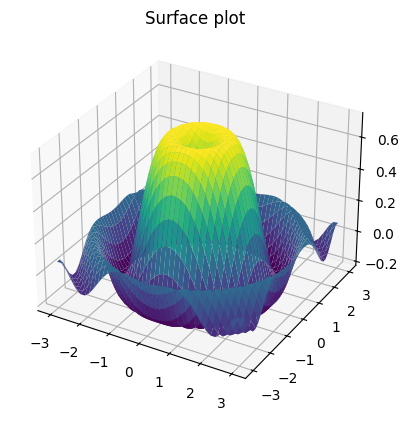

In [ ]:
def f(x, y):
    return(torch.sin(0.8*(x**2 + y**2)) / (x**2 + y**2)**(0.9))

noise_level = 0
mesh_size = 40
t = torch.linspace(-3, 3, mesh_size)
x, y = torch.meshgrid(t, t, indexing="xy")
z = f(x, y)
z_noisy = z + noise_level * torch.randn(mesh_size, mesh_size)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z_noisy,cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
plt.show()


# dataset creation
x_train = torch.vstack([x.ravel(), y.ravel()]).T
y_train = z_noisy.ravel()
y_test = z.ravel()

The following class encodes the architecture of a neural network with two hidden layers, for when the input data is 2-dimensional. We provide a simplified <tt>fit</tt> method to train the neural network. You are encouraged to understand the code, and what executing the functions will return so as to draw legitimate conclusions about the experiments.

In [ ]:
import dataclasses

@dataclasses.dataclass
class History:
    history: dict

class Net3L(nn.Module):

    def __init__(self, n_neurons_l1= 10, n_neurons_l2= 10):
        super(Net3L, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, n_neurons_l1),
            nn.ReLU(),
            nn.Linear(n_neurons_l1, n_neurons_l2),
            nn.ReLU(),
            nn.Linear(n_neurons_l2, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

    def fit(self, x_train, y_train, optimizer, batch_size, n_epochs_max, x_val=None, y_val=None):
        # Instantiate the train loader
        train_data = TensorDataset(x_train, y_train)
        train_loader = DataLoader(dataset =train_data, batch_size= batch_size, shuffle= True)
        # Beginning the optimization algorithm
        train_loss_list = []
        val_loss_list = []
        for n_epochs in range(n_epochs_max):
            # We train for a fixed number of epochs
            for x_batch, y_batch in train_loader:
                def closure():
                    optimizer.zero_grad()
                    output = self.forward(x_batch)
                    loss = nn.MSELoss()(output.squeeze(-1), y_batch)
                    loss.backward()
                    return loss
                loss = optimizer.step(closure)
            train_loss_list.append(loss.item())

            if x_val is not None and y_val is not None:
                val_loss_list.append(self.evaluate(x_val, y_val))
        history = {'loss': train_loss_list, 'val_loss': val_loss_list}
        return History(history)

    def evaluate(self, x_test, y_test):
      y_pred = self(x_test).squeeze(-1)
      return (nn.MSELoss()(y_pred, y_test)).item()

The cell below gives an example of what happens when the training is done using the L-BFGS algorithm. It can be adapted to other algorithms by modifying the arguments passed to the <tt>fit</tt> method.

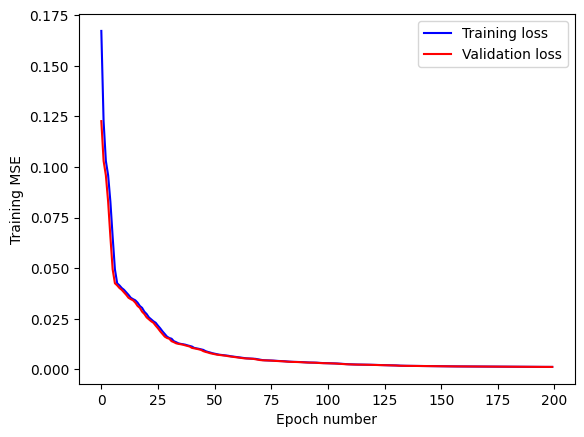

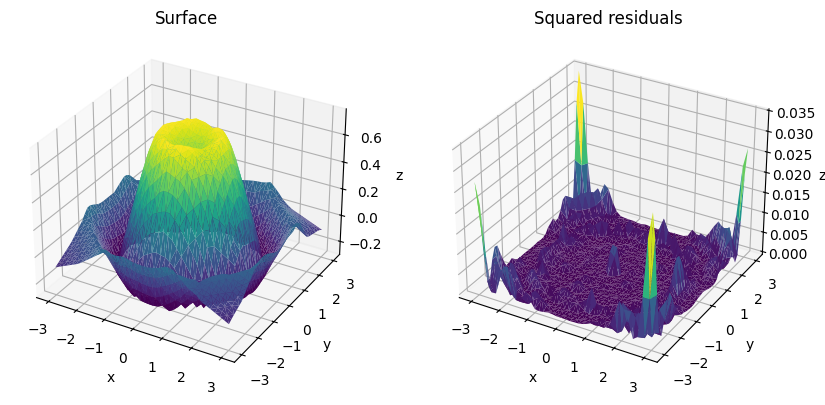

Training error: 0.0012613972648978233
Test error: 0.0012613972648978233


In [ ]:
net = Net3L(50, 50)
history = net.fit(
    x_train,
    y_train,
    optimizer=torch.optim.LBFGS(net.parameters(), lr=1, max_iter=1, line_search_fn='strong_wolfe'),
    batch_size=1600,
    n_epochs_max=200,
    x_val=x_train,
    y_val=y_test)

plt.figure()
plt.xlabel('Epoch number')
plt.ylabel('Training MSE')
plt.plot(history.history["loss"], color="blue")
plt.plot(history.history["val_loss"], color="red")
plt.legend(["Training loss", "Validation loss"])
plt.show()

y_pred = net(x_train).detach().squeeze(-1)

fig, ax = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={'projection': '3d'})
#
ax[0].plot_trisurf(x_train[:, 0], x_train[:, 1], y_pred, vmin=y_train.min(), cmap=cm.viridis)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_zlabel('z')
ax[0].set_title('Surface')
#
ax[1].plot_trisurf(x_train[:, 0], x_train[:, 1], (y_pred-y_train)**2, vmin=0, cmap=cm.viridis)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_zlabel('z')
ax[1].set_title('Squared residuals')
plt.show()

print('Training error:', net.evaluate(x_train, y_train))
print('Test error:', net.evaluate(x_train, y_test))

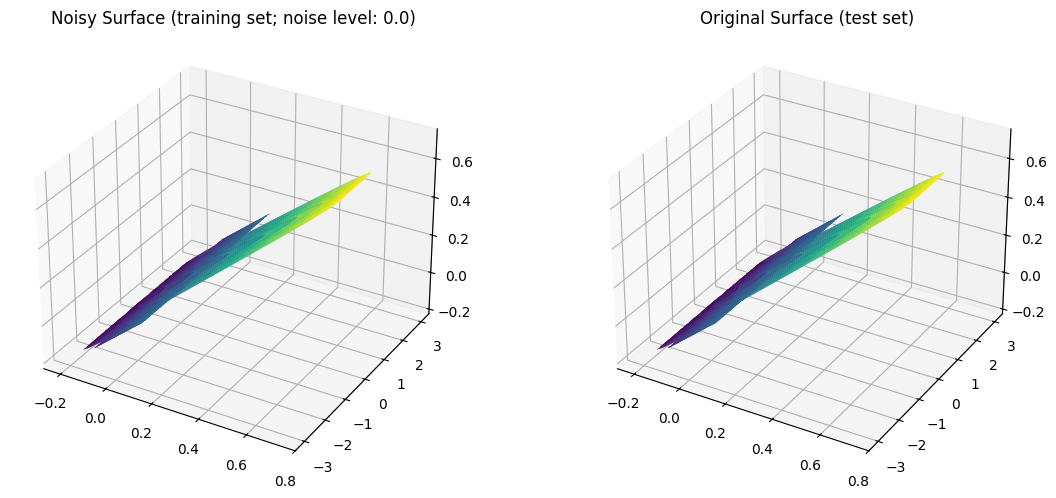

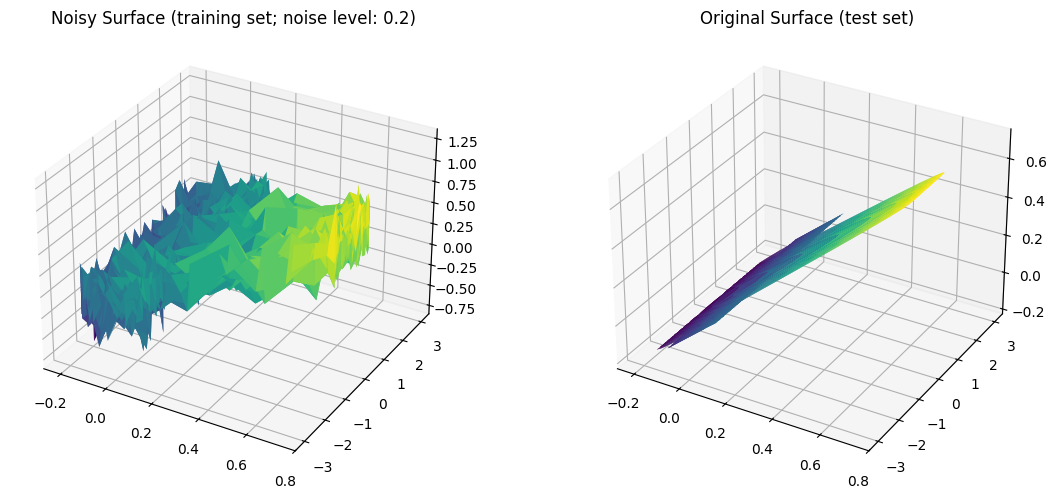

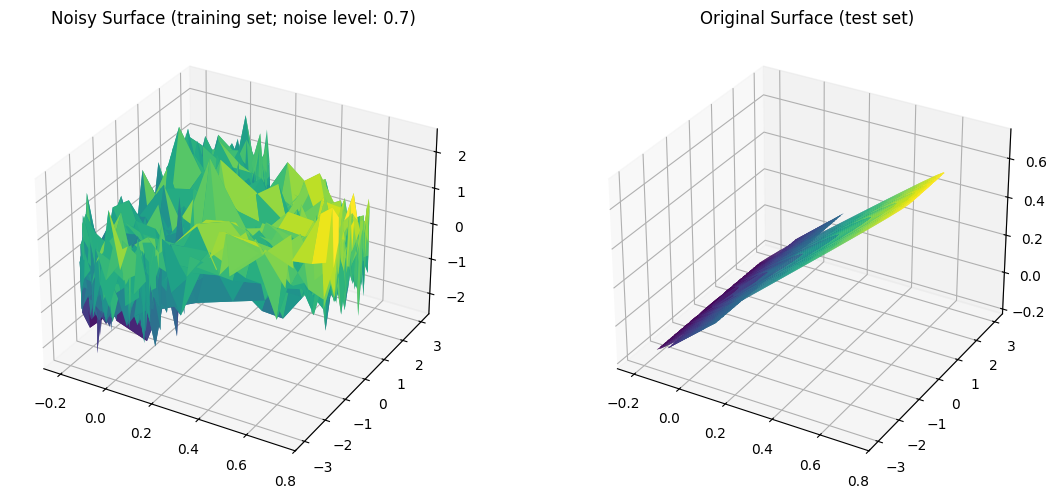

In [ ]:
def create_dataset(noise_level: float, show_plots: bool = False) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    mesh_size = 40
    t = torch.linspace(-3, 3, mesh_size)
    z, y = torch.meshgrid(t, t, indexing="xy")

    def f(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return torch.sin(0.8 * (x**2 + y**2)) / (x**2 + y**2) ** (0.9)

    z = f(z, y)
    z_noisy = z + noise_level * torch.randn(mesh_size, mesh_size)

    if show_plots:
        fig = plt.figure(figsize=(12, 5))

        ax2 = fig.add_subplot(1, 2, 1, projection='3d')
        surf2 = ax2.plot_surface(z, y, z_noisy, cmap="viridis", edgecolor="none")
        ax2.set_title(f"Noisy Surface (training set; noise level: {noise_level})")

        ax1 = fig.add_subplot(1, 2, 2, projection='3d')
        surf1 = ax1.plot_surface(z, y, z, cmap="viridis", edgecolor="none")
        ax1.set_title("Original Surface (test set)")

        plt.tight_layout()
        plt.show()

    x_train = torch.vstack([z.ravel(), y.ravel()]).T
    y_train = z_noisy.ravel()
    y_test = z.ravel()

    return x_train, y_train, y_test


x_train, y_train, y_test = create_dataset(noise_level=0.0, show_plots=True)
x_train, y_train, y_test = create_dataset(noise_level=0.2, show_plots=True)
x_train, y_train, y_test = create_dataset(noise_level=0.7, show_plots=True)

Impact of noise:

In [ ]:
noise_levels = [0.0, 0.25, 1.0]

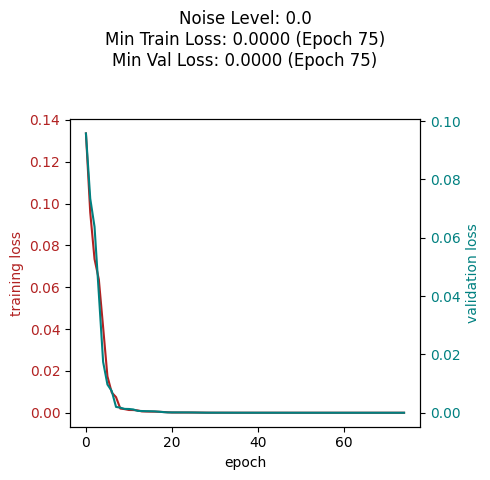

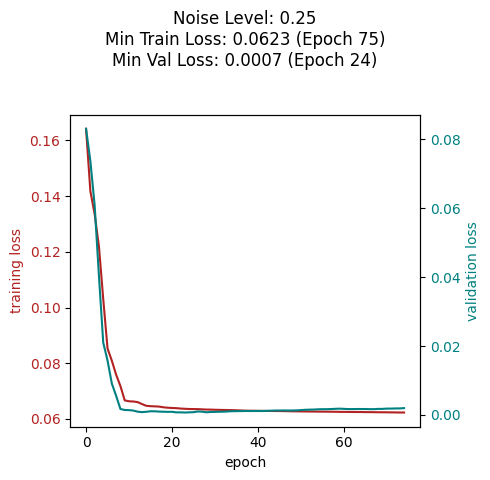

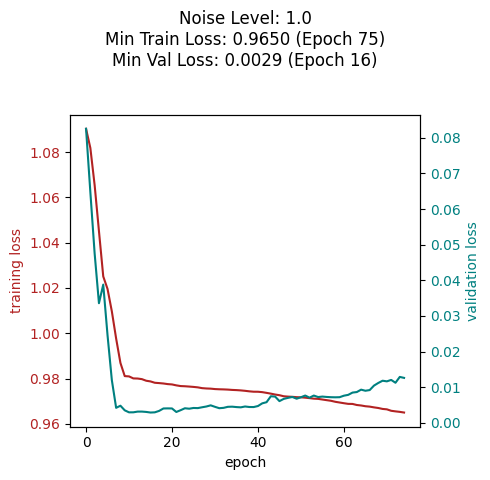

In [ ]:
for noise_level in noise_levels:
    x_train, y_train, y_test = create_dataset(noise_level=noise_level, show_plots=False)
    net = Net3L(50, 50)
    history = net.fit(
        x_train,
        y_train,
        optimizer=torch.optim.LBFGS(net.parameters(), lr=1, max_iter=1, line_search_fn='strong_wolfe'),
        batch_size=1600,
        n_epochs_max=75,
        x_val=x_train,
        y_val=y_test)

    # Find minimum loss values and their epochs
    min_train_loss = min(history.history['loss'])
    min_train_epoch = history.history['loss'].index(min_train_loss) + 1

    min_val_loss = min(history.history['val_loss'])
    min_val_epoch = history.history['val_loss'].index(min_val_loss) + 1

    fig, ax1 = plt.subplots(figsize=(5, 5))

    fig.suptitle(f"Noise Level: {noise_level}\n" \
                 f"Min Train Loss: {min_train_loss:.4f} (Epoch {min_train_epoch})\n" \
                 f"Min Val Loss: {min_val_loss:.4f} (Epoch {min_val_epoch})")

    color = 'firebrick'
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('training loss', color=color)
    ax1.plot(history.history['loss'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'teal'
    ax2.set_ylabel('validation loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(history.history['val_loss'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
    print()

    y_pred = net(x_train).detach().squeeze(-1)

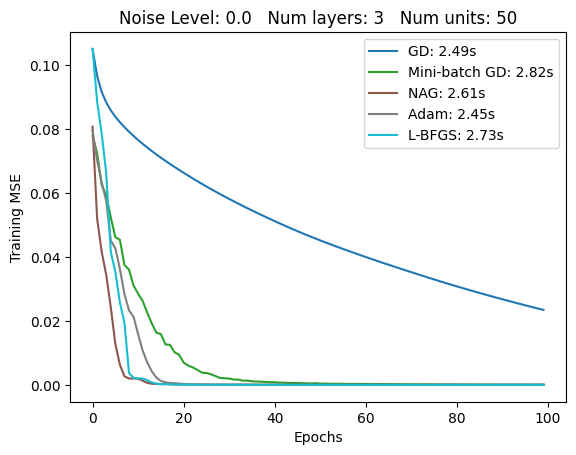

Training times: ['GD: 2.49s', 'Mini-batch GD: 2.82s', 'NAG: 2.61s', 'Adam: 2.45s', 'L-BFGS: 2.73s']
Evaluation performances: ['GD: 2.312e-02', 'Mini-batch GD: 9.894e-05', 'NAG: 3.045e-05', 'Adam: 1.906e-05', 'L-BFGS: 1.904e-06']


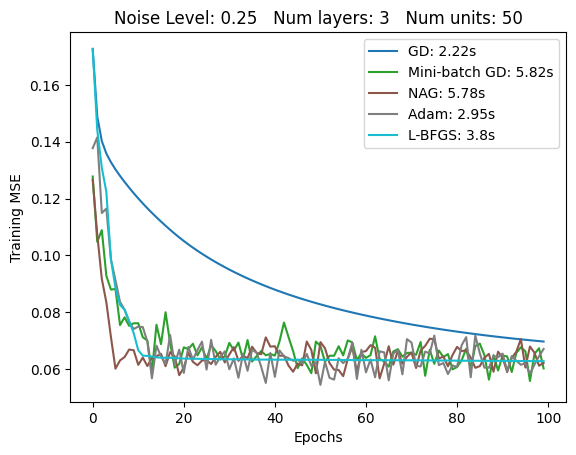

Training times: ['GD: 2.22s', 'Mini-batch GD: 5.82s', 'NAG: 5.78s', 'Adam: 2.95s', 'L-BFGS: 3.80s']
Evaluation performances: ['GD: 8.058e-03', 'Mini-batch GD: 7.187e-04', 'NAG: 5.422e-04', 'Adam: 4.805e-04', 'L-BFGS: 8.460e-04']


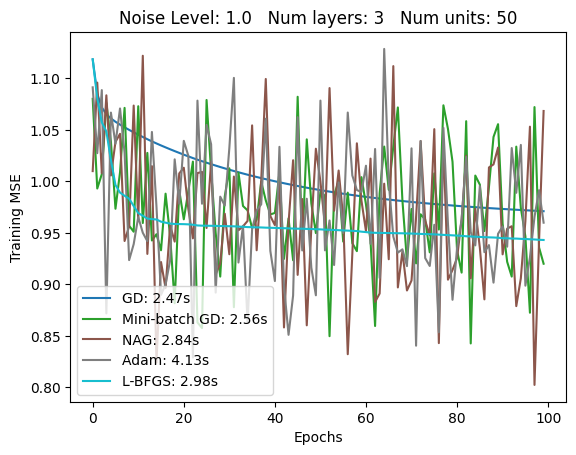

Training times: ['GD: 2.47s', 'Mini-batch GD: 2.56s', 'NAG: 2.84s', 'Adam: 4.13s', 'L-BFGS: 2.98s']
Evaluation performances: ['GD: 1.073e-02', 'Mini-batch GD: 4.116e-03', 'NAG: 4.812e-03', 'Adam: 6.053e-03', 'L-BFGS: 1.835e-02']


In [ ]:
num_layers = 3
num_neurons = 50
for noise_level in noise_levels:
    x_train, y_train, y_test = create_dataset(noise_level=noise_level, show_plots=False)
    # Example with a list of optimizers (running this cell takes ~5min with the default parameters)
    net = Net3L(num_neurons, num_neurons)
    # We create copies of this net so that every optimizer starts with the same initialization.
    net_list = [copy.deepcopy(net) for i in range(5)]
    # The number of epochs and other hyperparameters can (and should) be adapted to the point you're trying to make.
    n_epochs = 100
    gd = torch.optim.SGD(params=net_list[0].parameters(), lr=0.05)
    mini_batch_gd = torch.optim.SGD(params=net_list[1].parameters(), lr=0.1)
    nag = torch.optim.SGD(params=net_list[2].parameters(), lr=0.05, momentum=0.9, nesterov= True)
    adam = torch.optim.Adam(params=net_list[3].parameters())
    lbfgs = torch.optim.LBFGS(params=net_list[4].parameters(), lr=1, max_iter=1, line_search_fn='strong_wolfe')

    optimizer_list = [gd, mini_batch_gd, nag, adam, lbfgs]
    optimizer_names = ["GD", "Mini-batch GD", "NAG", "Adam", "L-BFGS"]
    batch_sizes_list = [1600, 400, 400, 400, 1600]
    times_list = []
    loss_meta_list = []
    eval_list = []

    for i, optimizer in enumerate(optimizer_list):
        t0 = time.time()
        history = net_list[i].fit(x_train, y_train, optimizer= optimizer, batch_size= batch_sizes_list[i], n_epochs_max= n_epochs)
        t1 = time.time()
        times_list.append(t1-t0)
        loss_meta_list.append(history.history['loss'])
        eval_list.append(net_list[i].evaluate(x_train, y_test))

    colors = cm.tab10(torch.linspace(0, 1, 5))
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Training MSE')
    for i in range(5):
        plt.plot(loss_meta_list[i], color= colors[i])
    plt.title(f"Noise Level: {noise_level}   " \
              f"Num layers: {num_layers}   " \
              f"Num units: {num_neurons}")
    plt.legend([f"{optimizer_names[i]}: {round(times_list[i], 2)}s" for i in range(5)])
    plt.show()

    print('Training times:', [f"{optimizer_names[i]}: {times_list[i]:.2f}s" for i in range(5)])
    print('Evaluation performances:', [f"{optimizer_names[i]}: {eval_list[i]:1.3e}" for i in range(5)])

Size of the network:

In [ ]:
nums_neurons = [10, 50, 100]

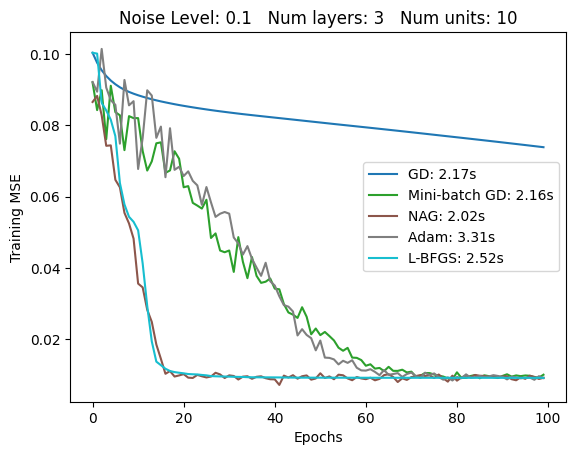

Training times: ['GD: 2.17s', 'Mini-batch GD: 2.16s', 'NAG: 2.02s', 'Adam: 3.31s', 'L-BFGS: 2.52s']
Evaluation performances: ['GD: 6.501e-02', 'Mini-batch GD: 2.963e-04', 'NAG: 1.671e-04', 'Adam: 2.183e-04', 'L-BFGS: 4.409e-05']


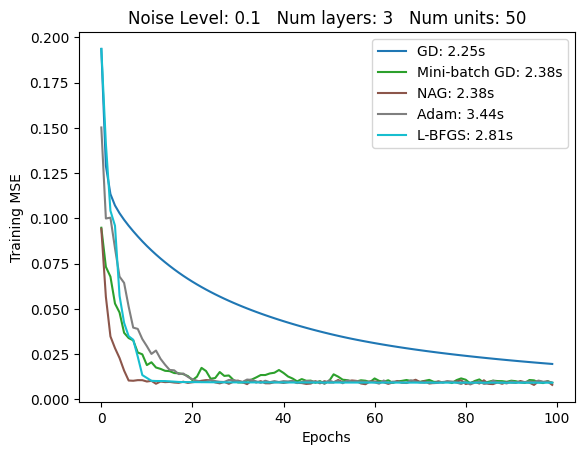

Training times: ['GD: 2.25s', 'Mini-batch GD: 2.38s', 'NAG: 2.38s', 'Adam: 3.44s', 'L-BFGS: 2.81s']
Evaluation performances: ['GD: 1.026e-02', 'Mini-batch GD: 8.436e-04', 'NAG: 2.129e-04', 'Adam: 2.273e-04', 'L-BFGS: 3.262e-04']


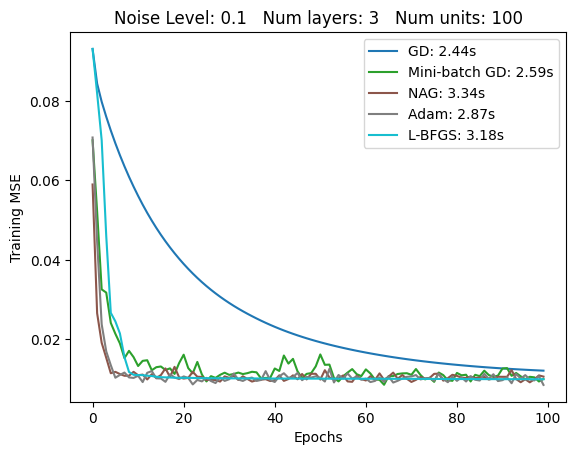

Training times: ['GD: 2.44s', 'Mini-batch GD: 2.59s', 'NAG: 3.34s', 'Adam: 2.87s', 'L-BFGS: 3.18s']
Evaluation performances: ['GD: 2.166e-03', 'Mini-batch GD: 7.532e-04', 'NAG: 2.802e-04', 'Adam: 1.797e-04', 'L-BFGS: 2.244e-04']


In [ ]:
noise_level = 0.1
for num_neurons in nums_neurons:
    x_train, y_train, y_test = create_dataset(noise_level=noise_level, show_plots=False)
    # Example with a list of optimizers (running this cell takes ~5min with the default parameters)
    net = Net3L(num_neurons, num_neurons)
    # We create copies of this net so that every optimizer starts with the same initialization.
    net_list = [copy.deepcopy(net) for i in range(5)]
    # The number of epochs and other hyperparameters can (and should) be adapted to the point you're trying to make.
    n_epochs = 100
    gd = torch.optim.SGD(params=net_list[0].parameters(), lr=0.05)
    mini_batch_gd = torch.optim.SGD(params=net_list[1].parameters(), lr=0.1 if num_neurons < 100 else 0.05)
    nag = torch.optim.SGD(params=net_list[2].parameters(), lr=0.05, momentum=0.9, nesterov= True)
    adam = torch.optim.Adam(params=net_list[3].parameters())
    lbfgs = torch.optim.LBFGS(params=net_list[4].parameters(), lr=1, max_iter=1, line_search_fn='strong_wolfe')

    optimizer_list = [gd, mini_batch_gd, nag, adam, lbfgs]
    optimizer_names = ["GD", "Mini-batch GD", "NAG", "Adam", "L-BFGS"]
    batch_sizes_list = [1600, 400, 400, 400, 1600]
    times_list = []
    loss_meta_list = []
    eval_list = []

    for i, optimizer in enumerate(optimizer_list):
        t0 = time.time()
        history = net_list[i].fit(x_train, y_train, optimizer= optimizer, batch_size= batch_sizes_list[i], n_epochs_max= n_epochs)
        t1 = time.time()
        times_list.append(t1-t0)
        loss_meta_list.append(history.history['loss'])
        eval_list.append(net_list[i].evaluate(x_train, y_test))

    colors = cm.tab10(torch.linspace(0, 1, 5))
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Training MSE')
    for i in range(5):
        plt.plot(loss_meta_list[i], color= colors[i])
    plt.title(f"Noise Level: {noise_level}   " \
              f"Num layers: {num_layers}   " \
              f"Num units: {num_neurons}")
    plt.legend([f"{optimizer_names[i]}: {round(times_list[i], 2)}s" for i in range(5)])
    plt.show()

    print('Training times:', [f"{optimizer_names[i]}: {times_list[i]:.2f}s" for i in range(5)])
    print('Evaluation performances:', [f"{optimizer_names[i]}: {eval_list[i]:1.3e}" for i in range(5)])

## Towards a bigger model

We now switch to a bigger model, used to perform classification over the MNIST dataset. This example is widely known in the machine learning community, and we follow the code in the footsteps of François Chollet, the creator of the <tt>keras</tt> library (https://keras.io/examples/vision/mnist_convnet/).

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
def build_model():
    return keras.Sequential(
        [
            keras.Input(shape=input_shape),
            keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )


model = build_model()

The following cell deals with the training of the model. Can you change the optimizer while still retaining the capabilities of the model trained with adam ?

In [ ]:
batch_size = 128
epochs = 15

# Modify the optimizer here
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.7643 - loss: 0.7583 - val_accuracy: 0.9793 - val_loss: 0.0808
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.9635 - loss: 0.1185 - val_accuracy: 0.9860 - val_loss: 0.0542
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9718 - loss: 0.0904 - val_accuracy: 0.9865 - val_loss: 0.0481
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.9794 - loss: 0.0685 - val_accuracy: 0.9882 - val_loss: 0.0437
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - accuracy: 0.9809 - loss: 0.0611 - val_accuracy: 0.9903 - val_loss: 0.0362
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9824 - loss: 0.0570 - val_accuracy: 0.9892 - val_loss: 0.0366
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - accuracy: 0.9834 - loss: 0.0520 - val_accuracy: 0.9890 - val_loss: 0.0385
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.9864 - loss: 0.0445 - 

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.023660078644752502
Test accuracy: 0.9922000169754028


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tempfile
import shutil
import os

batch_size = 128
epochs = 50  # allow more epochs since early stopping will terminate early
val_split = 0.1

# Define the learning rate schedule for SGD
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  # Adjust this value
    decay_rate=0.96,
    staircase=True)

for optim in [
    keras.optimizers.Adam(),
    keras.optimizers.SGD(learning_rate=lr_schedule),  # Use SGD with the decaying learning rate
    keras.optimizers.Adadelta(learning_rate=0.1),
]:
    print(f"Training with optimizer: {optim.__class__.__name__}")

    # Reset model
    model = build_model()

    # Callbacks
    tmp_dir = tempfile.mkdtemp()
    checkpoint_path = os.path.join(tmp_dir, "best_model.keras")

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
        ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')
    ]

    model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=["accuracy"])

    model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=val_split,
        callbacks=callbacks,
        verbose=2
    )

    # Load best model
    model.load_weights(checkpoint_path)
    shutil.rmtree(tmp_dir)  # Clean up temp files

    # Evaluate on test set
    score = model.evaluate(x_test, y_test, verbose=0)
    print(f"{optim.__class__.__name__} test loss: {score[0]:.4f}")
    print(f"{optim.__class__.__name__} test accuracy: {score[1]:.4f}\n")

Training with optimizer: Adam
Epoch 1/50
422/422 - 39s - 93ms/step - accuracy: 0.8895 - loss: 0.3678 - val_accuracy: 0.9790 - val_loss: 0.0851
Epoch 2/50
422/422 - 37s - 87ms/step - accuracy: 0.9669 - loss: 0.1107 - val_accuracy: 0.9843 - val_loss: 0.0578
Epoch 3/50
422/422 - 37s - 87ms/step - accuracy: 0.9744 - loss: 0.0833 - val_accuracy: 0.9867 - val_loss: 0.0479
Epoch 4/50
422/422 - 36s - 86ms/step - accuracy: 0.9784 - loss: 0.0698 - val_accuracy: 0.9883 - val_loss: 0.0436
Epoch 5/50
422/422 - 37s - 87ms/step - accuracy: 0.9810 - loss: 0.0611 - val_accuracy: 0.9882 - val_loss: 0.0429
Epoch 6/50
422/422 - 37s - 87ms/step - accuracy: 0.9830 - loss: 0.0562 - val_accuracy: 0.9897 - val_loss: 0.0383
Epoch 7/50
422/422 - 36s - 84ms/step - accuracy: 0.9835 - loss: 0.0523 - val_accuracy: 0.9890 - val_loss: 0.0380
Epoch 8/50
422/422 - 36s - 86ms/step - accuracy: 0.9856 - loss: 0.0482 - val_accuracy: 0.9907 - val_loss: 0.0334
Epoch 9/50
422/422 - 36s - 86ms/step - accuracy: 0.9862 - loss: 0.

# A personal regression example


For this exercise, you will work on a dataset that is built from your personal student number as indicated in the assignment. If you have trouble with loading the data, place the data.csv file in your working directory.

In [ ]:
try:
    data = pd.read_csv("data.csv", header= None).values.T
    print("Succesfully loaded data")
except:
    try:
        data_url = "https://github.com/KULasagna/ANN_DL_public/blob/master/session1/data.csv?raw=true"
        data = pd.read_csv(data_url, header= None).values.T
        print("Succesfully loaded data from repo")
    except:
        print(f"Please download the data.csv file from Toledo and place it in your working directory: {os.getcwd()}")

Succesfully loaded data from repo


In [ ]:
def dataset_generation(d1, d2, d3, d4, d5):
    T_new = (d1 * data[:, 2] + d2 * data[:, 3] + d3 * data[:, 4] + d4 * data[:, 5] + d5 * data[:, 6])/(d1 + d2 + d3 + d4 + d5)
    return T_new

x_values = data[:, 0:2]

T_new =  dataset_generation(9, 7, 2, 1, 2)  # in decreasing order

# Random subsampling to get the working dataset
idx = np.random.permutation(13600)

# training set
x_train = x_values[idx[0:2000]]
y_train = T_new[idx[0:2000]]

# test set
x_test = x_values[idx[2000:3000]]
y_test = T_new[idx[2000:3000]]

print('Number of training datapoints:', x_train.shape[0])
print('Number of testing datapoints:', x_test.shape[0])

Number of training datapoints: 2000
Number of testing datapoints: 1000


You can now plot the surface of the dataset. (Hint: use the function <tt> plot_trisurf </tt>)

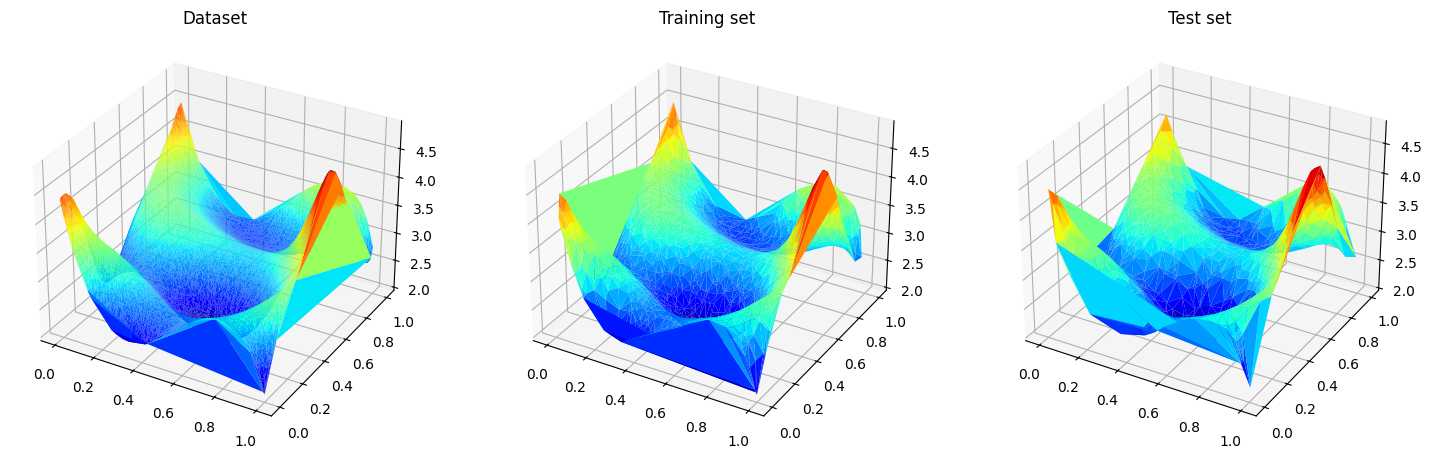

In [ ]:
def plot(*, datasets: list[tuple[np.ndarray, np.ndarray, str]], history_info: tuple[keras.callbacks.History, str] | None = None, title: str | None = None) -> None:
    num_history_subplots = 1 if history_info is not None else 0
    num_subplots = len(datasets) + num_history_subplots
    fig = plt.figure(figsize=(6 * num_subplots, 6))
    if title is not None:
        fig.suptitle(title)

    if history_info is not None:
        ax = fig.add_subplot(1, num_subplots, 1)
        ax.set_title(history_info[1])
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.plot(history_info[0].history["loss"], color="firebrick")
        plt.plot(history_info[0].history["val_loss"], color="teal")
        plt.legend(["Training loss", "Validation loss"])
        ax.set_box_aspect(0.9)

    for pos, (x, y, title) in enumerate(datasets):
        ax = fig.add_subplot(1, num_subplots, pos+1+num_history_subplots, projection="3d")
        ax.set_title(title)
        ax.plot_trisurf(x[:, 0], x[:, 1], y, cmap=cm.jet, linewidth=0.1)

    plt.show()


plot(datasets=[
    (x_values, T_new, "Dataset"),
    (x_train, y_train, "Training set"),
    (x_test, y_test, "Test set"),
])

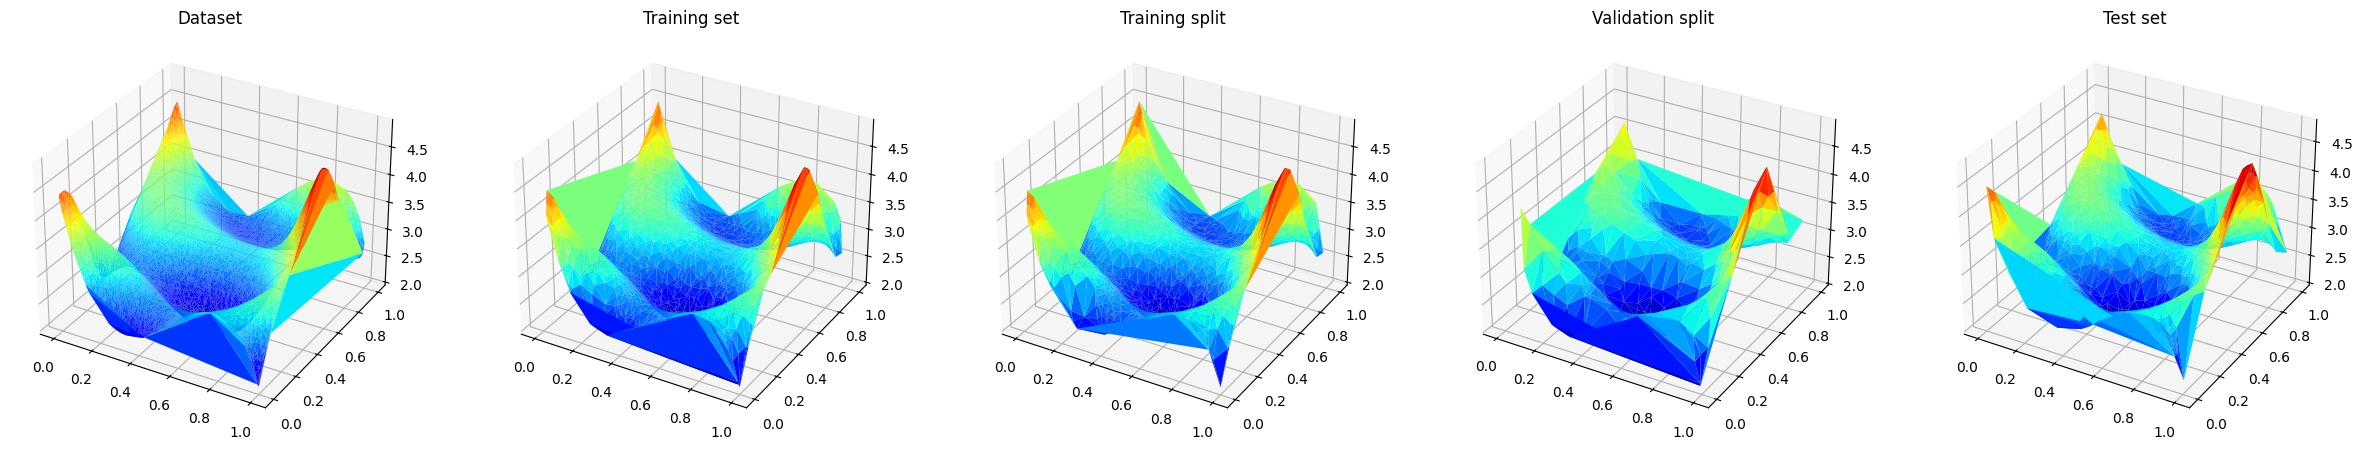

In [ ]:
from sklearn.model_selection import train_test_split

VALIDATION_SPLIT = 0.2

x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, y_train, test_size=VALIDATION_SPLIT, random_state=42)

plot(datasets=[
    (x_values, T_new, "Dataset"),
    (x_train, y_train, "Training set"),
    (x_train_split, y_train_split, "Training split"),
    (x_val_split, y_val_split, "Validation split"),
    (x_test, y_test, "Test set"),
])

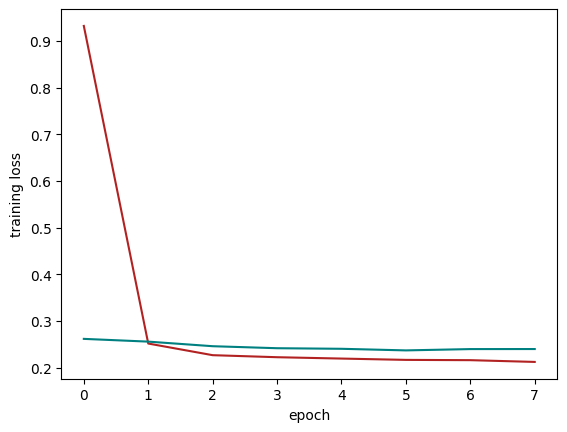

Last training error: 0.2123732566833496
Last validation error: 0.23998185992240906


In [ ]:
net = keras.Sequential([
            keras.layers.Input(shape= [x_train.shape[1]]),
            keras.layers.Dense(units= 3, activation='tanh'),
            keras.layers.Dense(units= 1),
  ])

net.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate= 0.05)
)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = net.fit(x_train, y_train, validation_split= 0.2, epochs= 20, batch_size= 64, callbacks= [callback], verbose= 0)

plt.figure()
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.plot(history.history['loss'], color= "firebrick")
plt.plot(history.history['val_loss'], color= 'teal')
plt.show()
print('Last training error:', history.history['loss'][-1])
print('Last validation error:', history.history['val_loss'][-1])

Once a model is trained, you can use it to assess the final performance of the model on the test set.

In [ ]:
y_pred = net.predict(x_test).squeeze(-1)
print('Final test error:', 0.5*((y_pred - y_test)**2).mean())

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step      
Final test error: 0.1099746209499718


In [ ]:
# Define hyperparameter grid
num_layers_options = [1, 2, 3, 4, 5, 10]
units_options = [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000] # Example values, adjust as needed
activation_options = ['relu', 'tanh']

best_val_loss = float('inf')
best_hparams = {}
results = []


# Iterate through hyperparameters
for num_layers in num_layers_options:
    for units in units_options:
        for activation in activation_options:

            layers = [keras.layers.Input(shape=[x_train.shape[1]])]
            for _ in range(num_layers):
                layers.append(keras.layers.Dense(units=units, activation=activation))
            layers.append(keras.layers.Dense(units=1))
            model = keras.Sequential(layers)

            model.compile(
                loss=keras.losses.MeanSquaredError(),
                optimizer=keras.optimizers.Adam(learning_rate=0.05)
            )

            callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            history = model.fit(
                x_train_split, y_train_split,
                validation_data=(x_val_split, y_val_split),
                epochs=100,  # Increased epochs for better convergence
                batch_size=64,
                callbacks=[callback],
                verbose=0
            )

            val_loss = model.evaluate(x_val_split, y_val_split, verbose=0)

            results.append({'num_layers': num_layers, 'units': units, 'activation': activation, 'val_loss': val_loss})

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_hparams = {'num_layers': num_layers, 'units': units, 'activation': activation}
                best_model = model  # Save the best model
                best_model_history = history

# TODO: tune optimiser, learning rate, etc.

# Evaluate final model on test set
test_loss = best_model.evaluate(x_test, y_test, verbose=0)

print("\nHyperparameter search complete.")
print("Best hyperparameters:", best_hparams)
print("Best validation loss:", best_val_loss)
print("Final test loss:", test_loss)

# Print all results
print("\nAll validation results:")
for result in results:
    print(result)


Hyperparameter search complete.
Best hyperparameters: {'num_layers': 2, 'units': 20, 'activation': 'tanh'}
Best validation loss: 0.006714929360896349
Final test loss: 0.00807198230177164

All validation results:
{'num_layers': 1, 'units': 10, 'activation': 'relu', 'val_loss': 0.1473931074142456}
{'num_layers': 1, 'units': 10, 'activation': 'tanh', 'val_loss': 0.2399979680776596}
{'num_layers': 1, 'units': 20, 'activation': 'relu', 'val_loss': 0.14477160573005676}
{'num_layers': 1, 'units': 20, 'activation': 'tanh', 'val_loss': 0.14005614817142487}
{'num_layers': 1, 'units': 30, 'activation': 'relu', 'val_loss': 0.23397037386894226}
{'num_layers': 1, 'units': 30, 'activation': 'tanh', 'val_loss': 0.13978642225265503}
{'num_layers': 1, 'units': 40, 'activation': 'relu', 'val_loss': 0.14326399564743042}
{'num_layers': 1, 'units': 40, 'activation': 'tanh', 'val_loss': 0.13789476454257965}
{'num_layers': 1, 'units': 50, 'activation': 'relu', 'val_loss': 0.1445082277059555}
{'num_layers': 1

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step      
Final test error: 0.00408


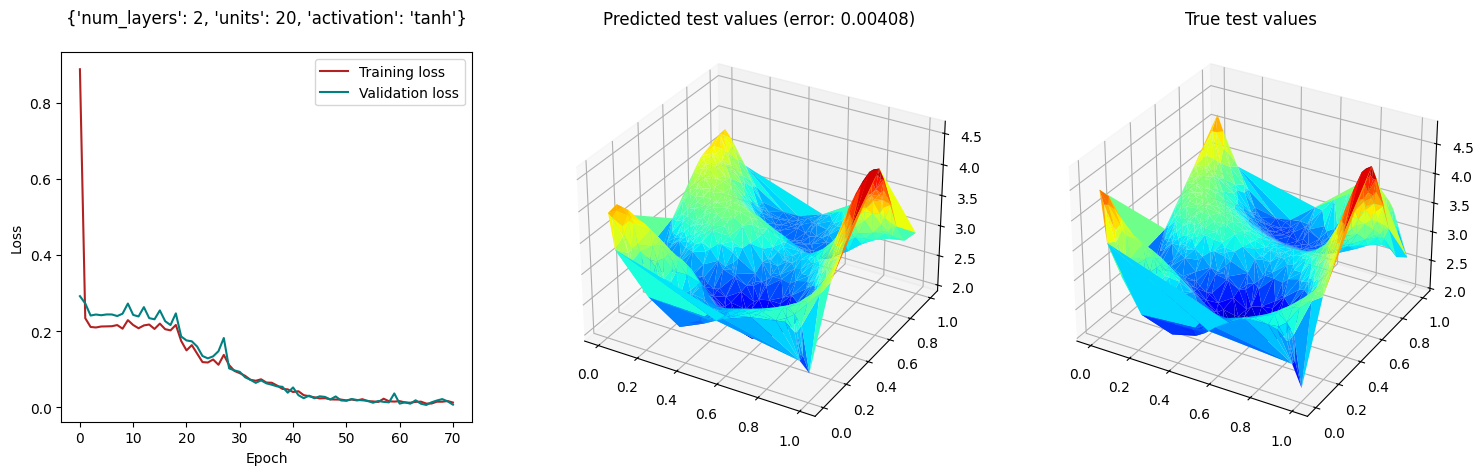

In [ ]:
y_pred = best_model.predict(x_test).squeeze(-1)
test_mse = round(0.5*((y_pred - y_test)**2).mean(), 5)
print('Final test error:', test_mse)

plot(datasets=[(x_test, y_pred, f"Predicted test values (error: {test_mse})"),
               (x_test, y_test, "True test values")], history_info=(best_model_history, f"{best_hparams}\n"))